# Telecom Operator Plans Revenue Evaluation

by Sasha Fridman, March 2024

<hr style="border: none; border-top: 2px solid black;">

<span style="font-size: 1.5em;">Table of Contents</span>

1. [📖 Project Description](#project-description)
2. [📚 Loading Data and Libraries](#loading-data-and-libraries)
3. [🔍 Data Exploration](#data-exploration)
4. [🛠️ Treating Missing Values](#treating-missing-values)
5. [🛠️ Fixing Data Types](#fixing-data-types)
6. [✨ Aggregating Data per User](#aggregating-data-per-user)
7. [🔍 Checking Cleaned Data](#checking-cleaned-data)
8. [🔍 Studying Parameters](#studying-parameters)
9. [🛠️ Treating Outliers](#treating-outliers)
10. [🔍 Studying Parameters Without Outliers](#studying-parameters-without-outliers)
11. [💲🚗 Average Prices by Vehicle Type](#average-prices-by-vehicle-type)
12. [💲🎨 The Other Price Factors](#the-other-price-factors)
13. [📝 General Conclusions](#general-conclusions)

***

## 📖 Project Description <a name="project-description"></a>

**In our task at the telecom operator Megaline, we analyze the behavior of clients who subscribe to prepaid plans**, Surf and Ultimate. The aim is **to determine which plan generates more revenue for the company**.

The objective is to conduct a preliminary analysis of the plans based on a sample of 500 Megaline clients. We will access data such as client demographics, plan usage, and communication activity (calls and text messages) throughout 2018. By carefully examining the behavior patterns of these clients, we seek to identify the plan that contributes most significantly to the revenue stream.

Through this analysis, we aim to provide valuable insights to the commercial department, enabling them to make strategic adjustments to advertising decisions.

## 📚 Loading Data and Libraries <a name="loading-data-and-libraries"></a>

In [1]:
pip install sidetable

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Loading all the libraries
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
sns.set(font_scale=1.1) #changing font size
import sidetable
import matplotlib.pyplot as plt
from scipy import stats as st

# we'll use the reduce() function to proceed the merger of several dataframes easier
from functools import reduce 

# printing more than 1 output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# making possible to display all columns/rows in output
pd.set_option ('display.max_columns', None)

In [3]:
# Load the data files into different dataframes
try:    
    df_users = pd.read_csv(r'C:\Users\4from\Desktop\Practicum\4 Statistical Data Analysis (SDA)\datasets\megaline_users.csv')
    df_calls = pd.read_csv(r'C:\Users\4from\Desktop\Practicum\4 Statistical Data Analysis (SDA)\datasets\megaline_calls.csv')
    df_messages = pd.read_csv(r'C:\Users\4from\Desktop\Practicum\4 Statistical Data Analysis (SDA)\datasets\megaline_messages.csv')
    df_internet = pd.read_csv(r'C:\Users\4from\Desktop\Practicum\4 Statistical Data Analysis (SDA)\datasets\megaline_internet.csv')
    df_plans = pd.read_csv(r'C:\Users\4from\Desktop\Practicum\4 Statistical Data Analysis (SDA)\datasets\megaline_plans.csv')
    
except:
    df_users = pd.read_csv('/datasets/megaline_users.csv')
    df_calls = pd.read_csv('/datasets/megaline_calls.csv')
    df_messages = pd.read_csv('/datasets/megaline_messages.csv')
    df_internet = pd.read_csv('/datasets/megaline_internet.csv')    
    df_plans = pd.read_csv('/datasets/megaline_plans.csv') 
    
# setting the names to our dataframes so we can refer to them later on     
df_users.name = 'df_users'   
df_calls.name = 'df_calls'
df_messages.name = 'df_messages'
df_internet.name = 'df_internet'
df_plans.name = 'df_plans'

## 🔍 Data Exploration  <a name="data-exploration"></a>

### Description of the Data

**The `users` table** (data on users):
- `user_id` — unique user identifier
- `first_name` — user's name
- `last_name` — user's last name
- `age` — user's age (years)
- `reg_date` — subscription date (dd, mm, yy)
- `churn_date` — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- `city` — user's city of residence
- `plan` — calling plan name

**The `calls` table** (data on calls):
- `id` — unique call identifier
- `call_date` — call date
- `duration` — call duration (in minutes)
- `user_id` — the identifier of the user making the call

**The `messages` table** (data on texts):
- `id` — unique text message identifier
- `message_date` — text message date
- `user_id` — the identifier of the user sending the text

**The `internet` table** (data on web sessions):
- `id` — unique session identifier
- `mb_used` — the volume of data spent during the session (in megabytes)
- `session_date` — web session date
- `user_id` — user identifier

**The `plans` table** (data on the plans):
- `plan_name` — calling plan name
- `usd_monthly_fee` — monthly charge in US dollars
- `minutes_included` — monthly minute allowance
- `messages_included` — monthly text allowance
- `mb_per_month_included` — data volume allowance (in megabytes)
- `usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- `usd_per_message` — price per text after exceeding the package limits
- `usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)


### Description of the Plans

Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

**Surf**
1. Monthly charge: dollars 20
2. 500 monthly minutes, 50 texts, and 15 GB of data
3. After exceeding the package limits:
- 1 minute: 3 cents
- 1 text message: 3 cents
- 1 GB of data: 10 dollars

**Ultimate**
1. Monthly charge: 70 dollars
2. 3000 monthly minutes, 1000 text messages, and 30 GB of data
3. After exceeding the package limits:
- 1 minute: 1 cent
- 1 text message: 1 cent
- 1 GB of data: 7 dollars

### Initial Data Inspection

Since we have several interconnected dataframes it looks reasonable to create a unified approach for checking them. For each dataframe we will study its' concise summary, overview - top rows, descriptive statistics, missing values and duplicates if any. Then we will address our findings.

In [4]:
# Checking the data

data = [df_users, df_calls, df_messages, df_internet, df_plans]

for df in data:
    print(f'\n Concise summary: {df.name}') 
    df.info()
    print(f'\n Top rows: {df.name}') 
    df.head(5)
    print(f'\n Descriptive statistics: {df.name}') 
    df.describe()
    print(f'\n Missing values: {df.name}') 
    df.stb.missing(style=True)
    print(f'\n Number of duplicates: {df.name}')
    df.duplicated().sum()
    print('Share of duplicates:', round(df.duplicated().mean(), 2), '%')
    print('-'*26)
    print(df[df.duplicated()].head(10))
    print('\n','='*100)
    


 Concise summary: df_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

 Top rows: df_users


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN



 Descriptive statistics: df_users


,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000



 Missing values: df_users


,missing,total,percent
churn_date,466,500,93.20%
user_id,0,500,0.00%
first_name,0,500,0.00%
last_name,0,500,0.00%
age,0,500,0.00%
city,0,500,0.00%
reg_date,0,500,0.00%
plan,0,500,0.00%



 Number of duplicates: df_users


0

Share of duplicates: 0.0 %
--------------------------
Empty DataFrame
Columns: [user_id, first_name, last_name, age, city, reg_date, plan, churn_date]
Index: []


 Concise summary: df_calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

 Top rows: df_calls


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22



 Descriptive statistics: df_calls


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000



 Missing values: df_calls


,missing,total,percent
id,0,"137,735",0.00%
user_id,0,"137,735",0.00%
call_date,0,"137,735",0.00%
duration,0,"137,735",0.00%



 Number of duplicates: df_calls


0

Share of duplicates: 0.0 %
--------------------------
Empty DataFrame
Columns: [id, user_id, call_date, duration]
Index: []


 Concise summary: df_messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB

 Top rows: df_messages


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26



 Descriptive statistics: df_messages


,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000



 Missing values: df_messages


,missing,total,percent
id,0,"76,051",0.00%
user_id,0,"76,051",0.00%
message_date,0,"76,051",0.00%



 Number of duplicates: df_messages


0

Share of duplicates: 0.0 %
--------------------------
Empty DataFrame
Columns: [id, user_id, message_date]
Index: []


 Concise summary: df_internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

 Top rows: df_internet


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22



 Descriptive statistics: df_internet


,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000



 Missing values: df_internet


,missing,total,percent
id,0,"104,825",0.00%
user_id,0,"104,825",0.00%
session_date,0,"104,825",0.00%
mb_used,0,"104,825",0.00%



 Number of duplicates: df_internet


0

Share of duplicates: 0.0 %
--------------------------
Empty DataFrame
Columns: [id, user_id, session_date, mb_used]
Index: []


 Concise summary: df_plans
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes

 Top rows: df_plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate



 Descriptive statistics: df_plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000



 Missing values: df_plans


,missing,total,percent
messages_included,0,2,0.00%
mb_per_month_included,0,2,0.00%
minutes_included,0,2,0.00%
usd_monthly_pay,0,2,0.00%
usd_per_gb,0,2,0.00%
usd_per_message,0,2,0.00%
usd_per_minute,0,2,0.00%
plan_name,0,2,0.00%



 Number of duplicates: df_plans


0

Share of duplicates: 0.0 %
--------------------------
Empty DataFrame
Columns: [messages_included, mb_per_month_included, minutes_included, usd_monthly_pay, usd_per_gb, usd_per_message, usd_per_minute, plan_name]
Index: []



### Observations

**General observations**
- data we see matches the Projects' description.
- no full duplicates revealed.
- seems the `user_id field` where presented is unique and thus the dataframes could be easily combined on it.  


**`df_users`**
- `reg_date` - object type (should be changed to datetime format)
- `churn_date` - object type (should be changed to datetime format)
- `churn_date` - 466 (93.20%) missing values (since this field represents the date the user stopped using the service, and some are still Megaline's clients, this missing values are normal and are not worth fixing somehow)

**`df_calls`**
- `call_date` - object type (should be changed to datetime format)
- `duration` - float type (since Megaline rounds seconds up to minutes we can round up the values and than make integer type of data instead of float)

**`df_messages`**
- `message_date` - object type (should be changed to datetime format)

**`df_internet`**
- `session_date` - object type (should be changed to datetime format)
- mb_used - float type (since individual web sessions are rounded up just for the month bases, it seems reasonable to leave float type here, as rounding up each session value can affect the total monthly figure. So we won't make integers here, at least not right at this stage).  

**`df_plans`**
- `usd_per_message` - float type (it seems worth leaving it as it is, since the price per message is in cents)
- `usd_per_minute` - float type (it seems worth leaving it as it is, since the price per message is in cents)

## 🔍🛠️ Studying and Treating Data Issues  <a name="studying-and-treating-data-issues"></a>

### Fixing Data Types

In [5]:
# let's fix data types as we mentioned above
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype('int')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

# checking the results
for df in data:
    print(f'\n Concise summary: {df.name}') 
    df.info()
    print('='*75)


 Concise summary: df_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB

 Concise summary: df_calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int

All is fine now, the data types are as wanted.

### Addressing Issues in the Categorical Fields

**By issues we mean duplicates in this case.**

Just in case, let's check the unique values of all the categorical characteristics to see whether they consist of unobvious duplicates where should be none. *We'll take action only if we find issues in the fields important for our studies*. By the way by use of Pandas duplicated() method we will check whether there are duplicated names, whether there should be non, like in the `user_id`field of all the dataframes we study (duplicates there would be crucial).

In [6]:
# checking duplicates in values where should be none 
for df in data:
    for characteristic in df: # going through all column names
        if df[characteristic].dtype=='object': #  if a column type is 'object'
            print(f'Number of duplicates found in {df.name}[\'{characteristic}\']: {df[characteristic].duplicated().sum()}\n') 
            print(f'{df.name}[\'{characteristic}\'] unique values: {df[characteristic].unique()}') # print its unique values
            print('='*100)

Number of duplicates found in df_users['first_name']: 42

df_users['first_name'] unique values: ['Anamaria' 'Mickey' 'Carlee' 'Reynaldo' 'Leonila' 'Livia' 'Jesusa'
 'Eusebio' 'Emely' 'Gerry' 'Wilber' 'Halina' 'Jonelle' 'Nicolas' 'Edmundo'
 'Beata' 'Jann' 'Boris' 'Dennis' 'Shizue' 'Rutha' 'Ricarda' 'Bo' 'Jack'
 'Yuki' 'Jess' 'Meggan' 'Georgeanna' 'Jefferey' 'Franklyn' 'Chase' 'Lane'
 'Delila' 'Latoyia' 'Jc' 'Jeff' 'Myron' 'Reena' 'Olympia' 'Flo' 'Paris'
 'Drucilla' 'Clementina' 'Carlos' 'Devora' 'Barney' 'Yuk' 'Linwood'
 'Loise' 'Jone' 'Rosario' 'Edmond' 'Piper' 'Denis' 'Patrick' 'Theo'
 'Reinaldo' 'Avril' 'Denisse' 'Maryam' 'Kristeen' 'Larhonda' 'Gerardo'
 'Sherlyn' 'Ariel' 'Robt' 'Marcel' 'Dino' 'Jacelyn' 'Isa' 'Seymour'
 'Grady' 'Particia' 'Salena' 'Ronny' 'Chau' 'Earnest' 'Brian' 'Neal'
 'Grayce' 'Dominic' 'Lyndia' 'Wiley' 'Ignacio' 'Adena' 'Lenard' 'Malena'
 'Brock' 'Taylor' 'Taren' 'Karima' 'Walter' 'Lilliam' 'Song' 'Deandre'
 'Collin' 'Shavon' 'Aaron' 'Sage' 'Marquitta' 'Moises' 

**Observations**  
- duplicates in the names of clients are normal. So we won't even check deeper this field.
- there are no unobvious duplicates in plan_name (just two rows there).
- duplicates in the `df_users` city field can affect our analysis (one of the Project's aim is to study the average revenue from users in NY-NJ area comparing to that of the users from other regions). So this field is worth further investigation. 
- no unobvious duplicates in the `user_id` field in all the dataframes.

In [7]:
# forming List of quantitative fields in the all dataframes
for df in data:
    for characteristic in df: # going through all column names
        if df[characteristic].dtype in ['float64', 'int64', 'int32']: 
            print(df.name, characteristic)

df_users user_id
df_users age
df_calls user_id
df_calls duration
df_messages user_id
df_internet user_id
df_internet mb_used
df_plans messages_included
df_plans mb_per_month_included
df_plans minutes_included
df_plans usd_monthly_pay
df_plans usd_per_gb
df_plans usd_per_message
df_plans usd_per_minute


In [8]:
# let's sort the names of cities to help check if there are any unobvious duplicates 
sorted(df_users['city'].unique())

['Albany-Schenectady-Troy, NY MSA',
 'Albuquerque, NM MSA',
 'Atlanta-Sandy Springs-Roswell, GA MSA',
 'Austin-Round Rock-Georgetown, TX MSA',
 'Bakersfield, CA MSA',
 'Baltimore-Columbia-Towson, MD MSA',
 'Baton Rouge, LA MSA',
 'Birmingham-Hoover, AL MSA',
 'Boston-Cambridge-Newton, MA-NH MSA',
 'Bridgeport-Stamford-Norwalk, CT MSA',
 'Buffalo-Cheektowaga, NY MSA',
 'Cape Coral-Fort Myers, FL MSA',
 'Charleston-North Charleston, SC MSA',
 'Charlotte-Concord-Gastonia, NC-SC MSA',
 'Chicago-Naperville-Elgin, IL-IN-WI MSA',
 'Cincinnati, OH-KY-IN MSA',
 'Cleveland-Elyria, OH MSA',
 'Colorado Springs, CO MSA',
 'Columbia, SC MSA',
 'Columbus, OH MSA',
 'Dallas-Fort Worth-Arlington, TX MSA',
 'Dayton-Kettering, OH MSA',
 'Denver-Aurora-Lakewood, CO MSA',
 'Detroit-Warren-Dearborn, MI MSA',
 'El Paso, TX MSA',
 'Fresno, CA MSA',
 'Grand Rapids-Kentwood, MI MSA',
 'Greensboro-High Point, NC MSA',
 'Houston-The Woodlands-Sugar Land, TX MSA',
 'Indianapolis-Carmel-Anderson, IN MSA',
 'Jackson

**Observations**  
Everything is fine with the names (we could use the lemmatization approaches for best possible checking for duplicates, but with the output given above seems we can get the job done well and fast without that in manual mode).

### Addressing Issues in the daytime Fields

**By issues here we mean values that stand out of the 2018 year that we study (or any other anomalies we may face).**

Since the datasets are pretty small, and we are going to display sorted values, the information would be easy for glancing at. 

In [9]:
for df in data:
    for characteristic in df: # going through all column names
        if df[characteristic].dtype=='datetime64[ns]': #  if a column type is 'object'
            print(f'Unique values in {df.name}[{characteristic}]') # print = unique values
            sorted(df[characteristic].unique())
            print('\n', '-'*50)

Unique values in df_users[reg_date]


[Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-01-04 00:00:00'),
 Timestamp('2018-01-05 00:00:00'),
 Timestamp('2018-01-07 00:00:00'),
 Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-01-09 00:00:00'),
 Timestamp('2018-01-10 00:00:00'),
 Timestamp('2018-01-11 00:00:00'),
 Timestamp('2018-01-12 00:00:00'),
 Timestamp('2018-01-13 00:00:00'),
 Timestamp('2018-01-14 00:00:00'),
 Timestamp('2018-01-15 00:00:00'),
 Timestamp('2018-01-16 00:00:00'),
 Timestamp('2018-01-17 00:00:00'),
 Timestamp('2018-01-18 00:00:00'),
 Timestamp('2018-01-19 00:00:00'),
 Timestamp('2018-01-20 00:00:00'),
 Timestamp('2018-01-21 00:00:00'),
 Timestamp('2018-01-24 00:00:00'),
 Timestamp('2018-01-25 00:00:00'),
 Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-01-27 00:00:00'),
 Timestamp('2018-01-28 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-02 00:00:00'),
 Timestamp('2018-02-04 00:00:00'),
 Timestamp('2018-02-05 00:00:00'),
 Timestamp('2018-02-


 --------------------------------------------------
Unique values in df_users[churn_date]


[NaT,
 Timestamp('2018-07-31 00:00:00'),
 Timestamp('2018-08-16 00:00:00'),
 Timestamp('2018-08-19 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-09-07 00:00:00'),
 Timestamp('2018-09-17 00:00:00'),
 Timestamp('2018-09-18 00:00:00'),
 Timestamp('2018-10-03 00:00:00'),
 Timestamp('2018-10-07 00:00:00'),
 Timestamp('2018-10-13 00:00:00'),
 Timestamp('2018-10-22 00:00:00'),
 Timestamp('2018-11-11 00:00:00'),
 Timestamp('2018-11-14 00:00:00'),
 Timestamp('2018-11-16 00:00:00'),
 Timestamp('2018-11-18 00:00:00'),
 Timestamp('2018-11-21 00:00:00'),
 Timestamp('2018-11-24 00:00:00'),
 Timestamp('2018-11-29 00:00:00'),
 Timestamp('2018-11-30 00:00:00'),
 Timestamp('2018-12-10 00:00:00'),
 Timestamp('2018-12-12 00:00:00'),
 Timestamp('2018-12-15 00:00:00'),
 Timestamp('2018-12-18 00:00:00'),
 Timestamp('2018-12-19 00:00:00'),
 Timestamp('2018-12-22 00:00:00'),
 Timestamp('2018-12-26 00:00:00'),
 Timestamp('2018-12-27 00:00:00'),
 Timestamp('2018-12-30 00:00:00'),
 Timestamp('20


 --------------------------------------------------
Unique values in df_calls[call_date]


[Timestamp('2018-01-15 00:00:00'),
 Timestamp('2018-01-16 00:00:00'),
 Timestamp('2018-01-17 00:00:00'),
 Timestamp('2018-01-18 00:00:00'),
 Timestamp('2018-01-19 00:00:00'),
 Timestamp('2018-01-20 00:00:00'),
 Timestamp('2018-01-21 00:00:00'),
 Timestamp('2018-01-22 00:00:00'),
 Timestamp('2018-01-23 00:00:00'),
 Timestamp('2018-01-24 00:00:00'),
 Timestamp('2018-01-25 00:00:00'),
 Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-01-27 00:00:00'),
 Timestamp('2018-01-28 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-01-30 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-02-02 00:00:00'),
 Timestamp('2018-02-03 00:00:00'),
 Timestamp('2018-02-04 00:00:00'),
 Timestamp('2018-02-05 00:00:00'),
 Timestamp('2018-02-06 00:00:00'),
 Timestamp('2018-02-07 00:00:00'),
 Timestamp('2018-02-08 00:00:00'),
 Timestamp('2018-02-09 00:00:00'),
 Timestamp('2018-02-10 00:00:00'),
 Timestamp('2018-02-11 00:00:00'),
 Timestamp('2018-02-


 --------------------------------------------------
Unique values in df_messages[message_date]


[Timestamp('2018-01-15 00:00:00'),
 Timestamp('2018-01-16 00:00:00'),
 Timestamp('2018-01-17 00:00:00'),
 Timestamp('2018-01-18 00:00:00'),
 Timestamp('2018-01-19 00:00:00'),
 Timestamp('2018-01-20 00:00:00'),
 Timestamp('2018-01-21 00:00:00'),
 Timestamp('2018-01-22 00:00:00'),
 Timestamp('2018-01-23 00:00:00'),
 Timestamp('2018-01-24 00:00:00'),
 Timestamp('2018-01-25 00:00:00'),
 Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-01-27 00:00:00'),
 Timestamp('2018-01-28 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-01-30 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-02-02 00:00:00'),
 Timestamp('2018-02-03 00:00:00'),
 Timestamp('2018-02-04 00:00:00'),
 Timestamp('2018-02-05 00:00:00'),
 Timestamp('2018-02-06 00:00:00'),
 Timestamp('2018-02-07 00:00:00'),
 Timestamp('2018-02-08 00:00:00'),
 Timestamp('2018-02-09 00:00:00'),
 Timestamp('2018-02-10 00:00:00'),
 Timestamp('2018-02-11 00:00:00'),
 Timestamp('2018-02-


 --------------------------------------------------
Unique values in df_internet[session_date]


[Timestamp('2018-01-15 00:00:00'),
 Timestamp('2018-01-16 00:00:00'),
 Timestamp('2018-01-17 00:00:00'),
 Timestamp('2018-01-18 00:00:00'),
 Timestamp('2018-01-19 00:00:00'),
 Timestamp('2018-01-20 00:00:00'),
 Timestamp('2018-01-21 00:00:00'),
 Timestamp('2018-01-22 00:00:00'),
 Timestamp('2018-01-23 00:00:00'),
 Timestamp('2018-01-24 00:00:00'),
 Timestamp('2018-01-25 00:00:00'),
 Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-01-27 00:00:00'),
 Timestamp('2018-01-28 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-01-30 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-02-02 00:00:00'),
 Timestamp('2018-02-03 00:00:00'),
 Timestamp('2018-02-04 00:00:00'),
 Timestamp('2018-02-05 00:00:00'),
 Timestamp('2018-02-06 00:00:00'),
 Timestamp('2018-02-07 00:00:00'),
 Timestamp('2018-02-08 00:00:00'),
 Timestamp('2018-02-09 00:00:00'),
 Timestamp('2018-02-10 00:00:00'),
 Timestamp('2018-02-11 00:00:00'),
 Timestamp('2018-02-


 --------------------------------------------------


**Observations**  
Everything looks fine with the dates. 

### Addressing issues in the quantitative fields

**By issues in these data we mean outliers.**

#### 📐 Creating a Unified Study Approach Function


**Since we need to study several parameters with a more or less unified approach, it's reasonable to create a universal but adjustable tool for this purpose. This tool would be a function** that would take our parameters as input and as output - present the following investigations.

For data visualization purposes:
- several histograms with different bins number (for versatile displaying of the data)
- two boxplots, the first displaying data with outliers, the second - without outliers

For data "cleaning" purposes:
- main descriptive statistics of a parameter that we study 
- upper and lower limits of outliers

As input this function will take:
- data frame of investigating parameter
- parameter that we study
- xlimit of a histogram (it would be handy to add this function parameter to make histograms more demonstrative)
- bins (numbers of bins of a histogram - plotted for each)
- extension for a title, if any
- whether to show information about outliers (we won't display this information when reanalyzing data after cleaning out outliers)

**For defining the limits of outliers we would use "1.5\*IQR aproach" (whiskers of boxplot).** But we won't do it blindly, e.g. **we'll use the "percentile approach" as well if it's reasonable** (since not all parameters can be treated in the same way).

*Thanks to the one of previous projects, this function is already in the workpiece, all that remains for us - just a minor adjustment.*

In [10]:
def distribution_IQR(df, parameter, xlimit, bins=[25, 75, 225], title_extension='', show_outliers_info=True):
    
    """
    As input this function takes:
     - data frame of a parameter
     - a parameter
     - xlimit of a histogram
     - bins of a histogram (plotted for each number of bins)
     - extension for a title, if any
     - whether to show information about outliers
    
    As outtput the function presents:    
     - several histograms with different bins number
     - two boxplots: the first displaying data with outliers, the second - without outliers
     - main descriptive statistics of parameter
     - upper and lower limits of outliers    
    """       
    for i in bins:    
        df[parameter].hist(bins=i, figsize=(7,3))
        plt.title(f'The Histogram of \"{parameter}\" {title_extension}, bins ={i}')       
        plt.xlabel(parameter)
        plt.ylabel('Frequency')
        plt.xlim(0, xlimit)
        plt.show() #showing plots separately                

    sns.boxplot(x=df[parameter],showfliers = True)
    plt.title(f'The Boxplot of {parameter} in {df.name} with outliers') 
    plt.show()
    sns.boxplot(x=df[parameter],showfliers = False)
    plt.title(f'The Boxplot of {parameter} in {df.name} without outliers') 
    plt.show()
   
    if df[parameter].mean()>df[parameter].median():
        print('The distribution is skewed to the right')
    else:
        print('The distribution is skewed to the left')
    print('---------------------------------------')
    print(f'Statistics on: {parameter}')
    print(df[parameter].describe())
    print('---------------------------------------')
    print('median: ',df[parameter].median())
    
    if show_outliers_info==True:
        Q1 = round(df[parameter].quantile(0.25))
        Q3 = round(df[parameter].quantile(0.75))
        IQR = Q3 - Q1
        min_iqr=Q1-round(1.5*IQR) 
        max_iqr=Q3+round(1.5*IQR)
        print('---------------------------------------')
        print('min border:',min_iqr)
        print('max border:',max_iqr)
        print('---------------------------------------')

        if min_iqr<0:
            print('The outliers are considered to be values above', max_iqr)
            print('We have',len(df[df[parameter]>max_iqr]),"values that we can consider outliers")
            print('Which makes', round(len(df[df[parameter]>max_iqr])/len(df[parameter])*100, 1), '% of the', parameter, 'data')
        else:        
            print('The outliers are considered to be values below',min_iqr, "and above",max_iqr)
            print('We have',len(df[(df[parameter]<min_iqr)|(df[parameter]>max_iqr)]),"values that we can consider outliers")
            print('Which makes', round(len(df[(df[parameter]<min_iqr)|(df[parameter]>max_iqr)]), 1), '% of the', parameter, 'data')


In [11]:
# forming List of quantitative fields in all dataframes
for df in data:
    for characteristic in df: # going through all column names
        if is_numeric_dtype(df[characteristic]):        
            print(df.name, characteristic)

df_users user_id
df_users age
df_calls user_id
df_calls duration
df_messages user_id
df_internet user_id
df_internet mb_used
df_plans messages_included
df_plans mb_per_month_included
df_plans minutes_included
df_plans usd_monthly_pay
df_plans usd_per_gb
df_plans usd_per_message
df_plans usd_per_minute


The following **fields seem to be worth further investigating: `age`, `duration`, `mb_used`.**

#### Studying the `age` Parameter

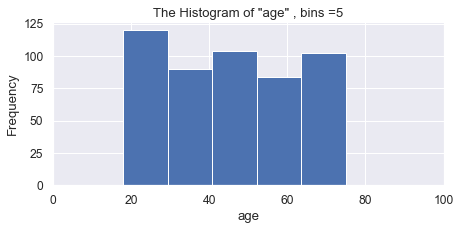

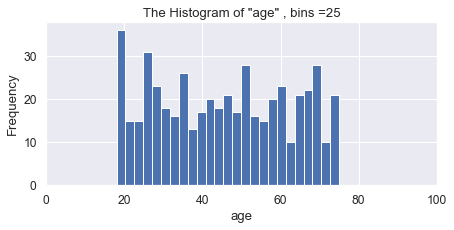

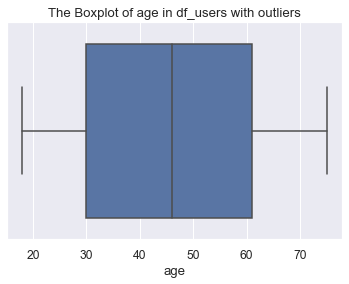

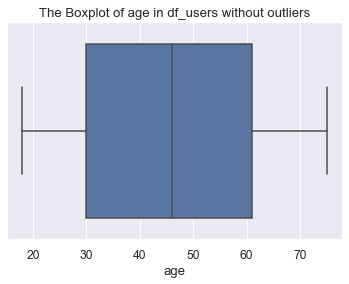

The distribution is skewed to the left
---------------------------------------
Statistics on: age
count    500.000000
mean      45.486000
std       16.972269
min       18.000000
25%       30.000000
50%       46.000000
75%       61.000000
max       75.000000
Name: age, dtype: float64
---------------------------------------
median:  46.0
---------------------------------------
min border: -16
max border: 107
---------------------------------------
The outliers are considered to be values above 107
We have 0 values that we can consider outliers
Which makes 0.0 % of the age data


In [12]:
distribution_IQR(df=df_users, parameter='age', xlimit=100, bins=[5, 25], show_outliers_info=True)

**Observations**  
Everything looks fine with ages, no data intervention needed.

#### Studying the `duration` Parameter

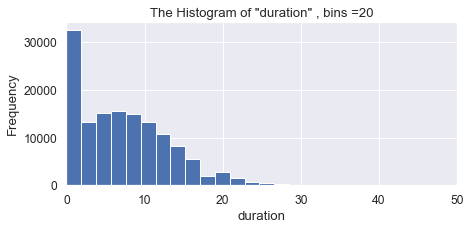

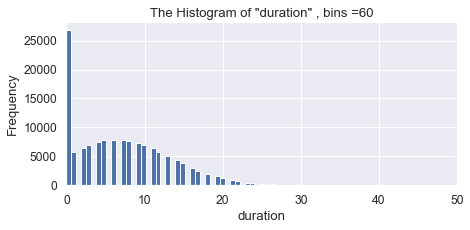

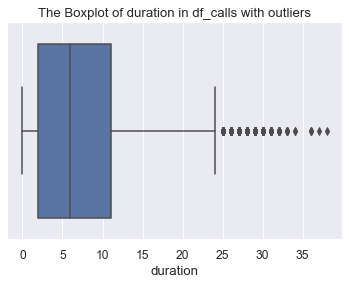

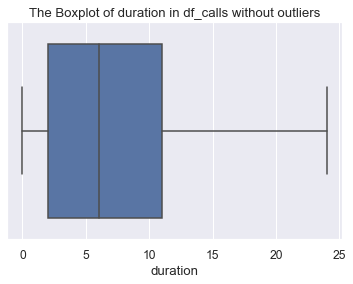

The distribution is skewed to the right
---------------------------------------
Statistics on: duration
count    137735.000000
mean          7.146673
std           5.953919
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64
---------------------------------------
median:  6.0
---------------------------------------
min border: -12
max border: 25
---------------------------------------
The outliers are considered to be values above 25
We have 466 values that we can consider outliers
Which makes 0.3 % of the duration data


In [13]:
distribution_IQR(df=df_calls, parameter='duration', xlimit=50, bins=[20, 60], show_outliers_info=True)

In [14]:
# checking potential outliers above max border of the duration field
df_calls.query('duration>25').sort_values(by = 'duration', ascending=False)

,id,user_id,call_date,duration
31355,1117_329,1117,2018-09-10,38
129871,1467_107,1467,2018-08-11,37
133587,1483_438,1483,2018-06-10,36
92135,1331_26,1331,2018-11-14,36
31180,1117_154,1117,2018-09-11,36
...,...,...,...,...
101845,1362_604,1362,2018-11-04,26
102108,1362_873,1362,2018-07-17,26
40632,1150_203,1150,2018-11-24,26
40219,1148_100,1148,2018-12-13,26


The share of potential outliers above max border revealed by  "1.5*IQR approach" is insignificant, just 0,3% We don't see any values standing too far from the average and thus seriously affecting the mean. Moreover, the 25 to 38 minutes duration of calls seem quite reasonable. So we can leave the data max border as it is in this field, without "fixing" predetermined outliers.

At the same time, there are some strange values at the very bottom of this field, that are not determined as outliers by "1.5*IQR approach"  but they are very flashy in the graphs. Let's check them.

In [15]:
# checking potential outliers at the bottom of the duration field
df_calls.query('duration<1')
len(df_calls.query('duration<1'))/len(df_calls)*100 # %of the whole dataframe 

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0
25,1001_13,1001,2018-12-24,0
31,1001_30,1001,2018-10-17,0
32,1001_31,1001,2018-11-03,0
34,1001_35,1001,2018-12-21,0
...,...,...,...,...
137714,1499_183,1499,2018-11-10,0
137715,1499_184,1499,2018-09-15,0
137720,1499_189,1499,2018-12-27,0
137722,1499_191,1499,2018-12-24,0


19.482339274694162

The share of zero duration calls is substantial, almost 1/5 of all the cases.
*Let's recollect that Megaline rounds seconds up to minutes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute.*
But since we see here zeros in durations field, it must mean that these records of data reflect attempts of calls not calls in fact (e.g. a person tried to reach someone, but there was no reply). Otherwise we would see "1" not "0" in duration field in such cases).

As these figures significantly affect the whole picture and further analysis it seems reasonable no treat them as outliers and get rid of them. 

In [16]:
# getting rid of 0 values in the duration field
len(df_calls) # number of calls before fixing the data
df_calls = df_calls.query('duration>1').reset_index()
df_calls.name = 'df_calls' #refreshing the name, otherwise we won't be able to refer to it anymore
len(df_calls) # number of calls after fixing the data

137735

105106

#### Studying the `duration` Parameter with Fixed Zero Values

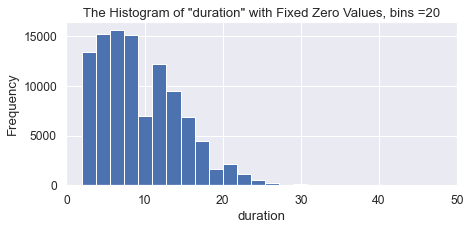

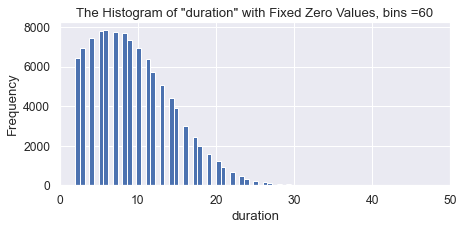

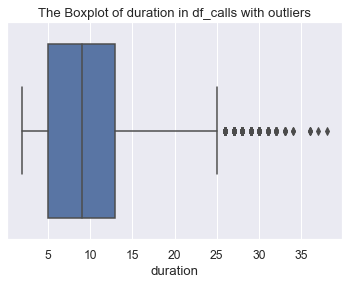

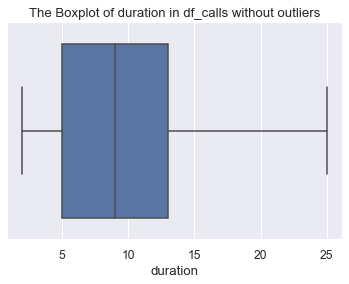

The distribution is skewed to the right
---------------------------------------
Statistics on: duration
count    105106.000000
mean          9.310144
std           5.162415
min           2.000000
25%           5.000000
50%           9.000000
75%          13.000000
max          38.000000
Name: duration, dtype: float64
---------------------------------------
median:  9.0
---------------------------------------
min border: -7
max border: 25
---------------------------------------
The outliers are considered to be values above 25
We have 466 values that we can consider outliers
Which makes 0.4 % of the duration data


In [17]:
distribution_IQR(df=df_calls, parameter='duration', xlimit=50, title_extension='with Fixed Zero Values', bins=[20, 60], show_outliers_info=True)

The cleaned data looks much better. 

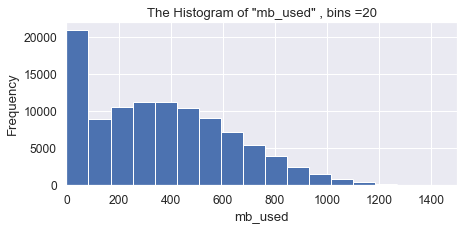

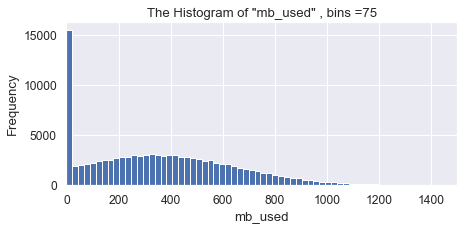

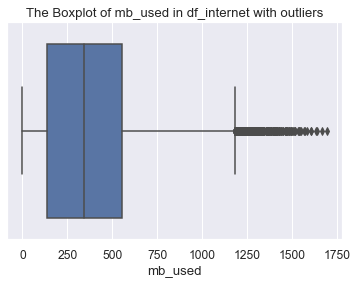

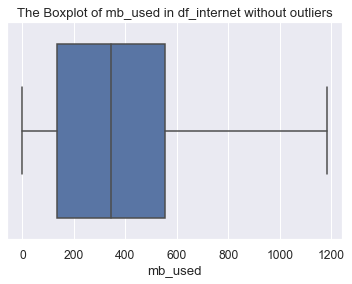

The distribution is skewed to the right
---------------------------------------
Statistics on: mb_used
count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64
---------------------------------------
median:  343.98
---------------------------------------
min border: -492
max border: 1183
---------------------------------------
The outliers are considered to be values above 1183
We have 422 values that we can consider outliers
Which makes 0.4 % of the mb_used data


In [18]:
# studying the mb_used parameter
distribution_IQR(df=df_internet, parameter='mb_used', xlimit=1500, bins=[20, 75], show_outliers_info=True)

In [19]:
# checking potential outliers above max border of the duration field
df_internet.query('mb_used>1183').sort_values(by = 'mb_used', ascending=False)

,id,user_id,session_date,mb_used
92312,1430_447,1430,2018-12-30,1693.47
4683,1028_241,1028,2018-03-14,1668.03
87217,1404_84,1404,2018-12-15,1636.47
37647,1171_18,1171,2018-03-02,1634.39
68534,1320_198,1320,2018-10-25,1604.46
...,...,...,...,...
59360,1268_29,1268,2018-06-12,1184.14
82196,1384_443,1384,2018-10-02,1184.03
48497,1215_219,1215,2018-09-17,1183.87
76586,1359_270,1359,2018-08-22,1183.79


The picture of mb_used field looks very close to that of duration that we studied above. 
The share of potential outliers above max border revealed by  "1.5*IQR approach" is insignificant, just 0,4% We don't see any values standing too far from the average and thus seriously affecting the mean. Moreover, the 1183 to 1693 MB used seem quite reasonable. So we can leave the data max border as it is in this field, without "fixing" predetermined outliers.

At the same time there some strange values at the very bottom of this field, that are not determined as outliers by "1.5*IQR approach"  but they are very flashy at the graphs. Let's check them.

In [20]:
# checking potential outliers at the bottom of the duration field
df_internet.query('mb_used<1')
len(df_internet.query('mb_used<1'))/len(df_internet)*100 # %of the whole dataframe 

,id,user_id,session_date,mb_used
1,1000_204,1000,2018-12-31,0.0
14,1001_26,1001,2018-09-17,0.0
16,1001_28,1001,2018-10-17,0.0
34,1001_54,1001,2018-09-02,0.0
43,1001_77,1001,2018-10-31,0.0
...,...,...,...,...
104797,1499_192,1499,2018-09-19,0.0
104804,1499_199,1499,2018-12-09,0.0
104816,1499_211,1499,2018-09-26,0.0
104817,1499_212,1499,2018-09-11,0.0


13.192463629859288

The share of zero values in mb_used field is weighty - 13%.
It's not easy to guess what these zeros in mb_used field stand for. Probably they reflect cases when users were online but didn't consume any information in the internet (zero traffic = zero MB used). In any case these data doesn't seem valuable, but it may bring 'noize' into our analysis, so we better get rid of it. 

In [21]:
# getting rid of 0 values in the mb_used field
len(df_internet) # number of calls before fixing the data
df_internet = df_internet.query('mb_used>1').reset_index()
df_internet.name = 'df_internet' #refreshing the name, otherwise we won't be able to refer to it anymore
len(df_internet) # number of calls after fixing the data

104825

90996

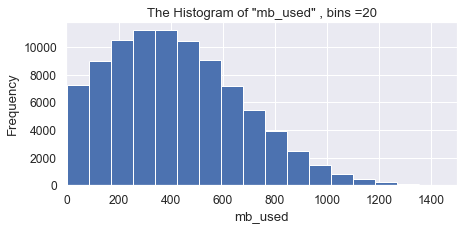

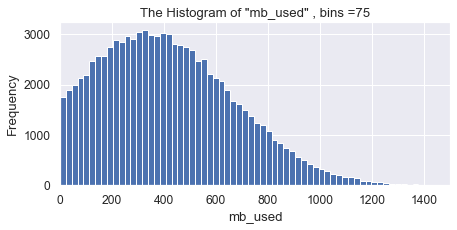

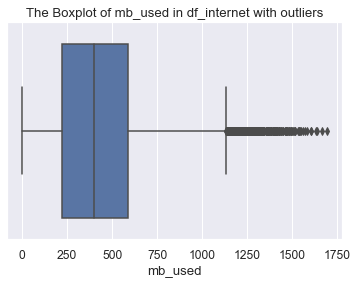

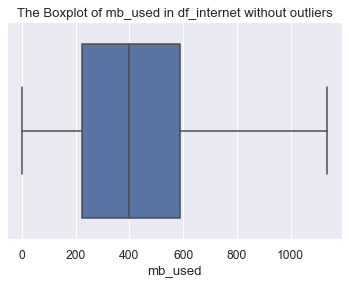

The distribution is skewed to the right
---------------------------------------
Statistics on: mb_used
count    90996.000000
mean       422.444132
std        254.864063
min          1.010000
25%        223.870000
50%        396.315000
75%        588.490000
max       1693.470000
Name: mb_used, dtype: float64
---------------------------------------
median:  396.315
---------------------------------------
min border: -322
max border: 1134
---------------------------------------
The outliers are considered to be values above 1134
We have 665 values that we can consider outliers
Which makes 0.7 % of the mb_used data


In [22]:
# studying the mb_used parameter after fixing zero values
distribution_IQR(df=df_internet, parameter='mb_used', xlimit=1500, bins=[20, 75], show_outliers_info=True)

The cleaned data looks much better. 

## ✨ Enriching Data <a name="Project-Description"></a>

Since later on we are going to analyze the data grouped on the monthly bases it would be handy to get monthly values based on the following fields: call_date, message_date, session_date. Let's add them. 

In [23]:
# adding monthly daytime fields
df_calls['month'] = df_calls['call_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month

# checking the result
df_calls.sample(3)
df_messages.sample(3)
df_internet.sample(3)

,index,id,user_id,call_date,duration,month
58115,76073,1268_577,1268,2018-11-22,5,11
24356,31886,1120_264,1120,2018-04-19,6,4
80517,105493,1372_30,1372,2018-12-23,18,12


,id,user_id,message_date,month
6153,1055_271,1055,2018-11-24,11
11326,1077_597,1077,2018-10-19,10
63125,1401_46,1401,2018-10-25,10


,index,id,user_id,session_date,mb_used,month
41113,47355,1211_232,1211,2018-08-25,319.75,8
5762,6592,1038_80,1038,2018-11-14,321.65,11
9039,10357,1053_399,1053,2018-09-30,69.19,9


All is fine with the new fields, as we wanted.

Since later on we are going to analyze data in gigabites it's worth adding the appropriate field.

In [24]:
# adding gb_used field
df_internet['gb_used'] = df_internet['mb_used']/1024

# checking the result
df_internet.sample(3)

,index,id,user_id,session_date,mb_used,month,gb_used
75754,87220,1404_87,1404,2018-09-12,462.58,9,0.451738
57327,66156,1305_383,1305,2018-07-10,459.21,7,0.448447
30879,35570,1160_274,1160,2018-08-14,281.82,8,0.275215


### Summary on Data Preparation

What we've done so far:
- fixed the data types, from object to datetime, from float to integer, when needed
- studied full duplicates and duplicates in separate fields where they could affect the analysis (like cities of customers), and no duplicates were detected. 
- studying issues (like values outside the 2018 year) in the daytime fields, no issues were detected there
- studying issues in the quantitative fields like `age`, `duration`, `mb_used`. Everything was fine in ages; in `duration` and `mb_used` we fixed unreasonable zero values, and we treated them as outliers.
- enriched data for further analysis by adding appropriate months fields for such categories as `call_date`, `message_date`, and `session_date`. And also added the `gb_use`d column, based on the `mb_used` field.

## 🧩 Aggregating Data per User <a name="aggregating-data-per-user"></a>

Now, as the data is clean, let's aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.

In [25]:
# Calculate the number of calls made by each user per month.
df_calls_by_user_count = df_calls.groupby(by = ['user_id', 'month'])['duration'].count().reset_index() 

# renaming and checking the columns
df_calls_by_user_count.columns = ['user_id', 'month', 'calls_number']
df_calls_by_user_count.head(5)

,user_id,month,calls_number
0,1000,12,16
1,1001,8,21
2,1001,9,38
3,1001,10,44
4,1001,11,43


In [26]:
# Calculate the amount of minutes spent by each user per month. Save the result.
df_calls_by_user_sum = df_calls.groupby(by = ['user_id', 'month'])['duration'].sum().reset_index()

# renaming and checking the columns
df_calls_by_user_sum.columns = ['user_id', 'month', 'calls_duration']
df_calls_by_user_sum.head(5)

,user_id,month,calls_duration
0,1000,12,124
1,1001,8,181
2,1001,9,315
3,1001,10,390
4,1001,11,420


In [27]:
# Calculate the number of messages sent by each user per month. Save the result.
df_messages_by_user = df_messages.groupby(by = ['user_id', 'month'])['id'].count().reset_index()

# renaming and checking the columns
df_messages_by_user.columns = ['user_id', 'month', 'messages_number']
df_messages_by_user.head(5)

,user_id,month,messages_number
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [28]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
df_traffic_by_user = df_internet.groupby(by = ['user_id', 'month'])['gb_used'].sum().reset_index()

df_traffic_by_user.head(5)

,user_id,month,gb_used
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605


In [29]:
# as according Megaline's plans traffic is rounded up in GB on monthly bases, we can round it up right now, since we grouped the data by months. 
df_traffic_by_user['gb_used'] = df_traffic_by_user['gb_used'].apply(np.ceil)

df_traffic_by_user.head(5)

,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0


In [30]:
# Merging the data for calls, minutes, messages, internet based on user_id and month 
# so that one record in it would represent what an unique user consumed in a given month.

# list of dataframes to be merged
dfs_to_be_merged = [df_calls_by_user_count, df_calls_by_user_sum , df_messages_by_user, df_traffic_by_user]

# merge all dataframes into one
df_merged = reduce(lambda  left, right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs_to_be_merged)\
            .fillna(0) # empty cells will be filled with ‘0‘ instead of NaN 

# checking result of the merger
df_merged
df_merged.info()
df_merged.sample(10)

,user_id,month,calls_number,calls_duration,messages_number,gb_used
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,21.0,181.0,30.0,7.0
2,1001,9,38.0,315.0,44.0,14.0
3,1001,10,44.0,390.0,53.0,22.0
4,1001,11,43.0,420.0,36.0,19.0
...,...,...,...,...,...,...
2288,1407,11,0.0,0.0,1.0,1.0
2289,1482,10,0.0,0.0,2.0,0.0
2290,1094,10,0.0,0.0,0.0,2.0
2291,1108,12,0.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          2293 non-null   int64  
 1   month            2293 non-null   int32  
 2   calls_number     2293 non-null   float64
 3   calls_duration   2293 non-null   float64
 4   messages_number  2293 non-null   float64
 5   gb_used          2293 non-null   float64
dtypes: float64(4), int32(1), int64(1)
memory usage: 98.7 KB


,user_id,month,calls_number,calls_duration,messages_number,gb_used
514,1110,11,43.0,386.0,34.0,20.0
2178,1483,6,54.0,488.0,5.0,13.0
555,1120,8,45.0,408.0,47.0,19.0
1581,1351,11,13.0,132.0,18.0,23.0
1742,1384,8,28.0,232.0,92.0,19.0
2076,1458,11,25.0,243.0,30.0,17.0
1373,1304,12,50.0,533.0,59.0,23.0
336,1072,10,64.0,609.0,15.0,27.0
734,1157,9,61.0,526.0,0.0,10.0
1278,1279,10,47.0,500.0,23.0,13.0


In [31]:
# let's also add the data about users by merging the dataframe above with df_users
df_total = pd.merge(left=df_users, right=df_merged, on="user_id", how='outer')
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          2303 non-null   int64         
 1   first_name       2303 non-null   object        
 2   last_name        2303 non-null   object        
 3   age              2303 non-null   int64         
 4   city             2303 non-null   object        
 5   reg_date         2303 non-null   datetime64[ns]
 6   plan             2303 non-null   object        
 7   churn_date       160 non-null    datetime64[ns]
 8   month            2293 non-null   float64       
 9   calls_number     2293 non-null   float64       
 10  calls_duration   2293 non-null   float64       
 11  messages_number  2293 non-null   float64       
 12  gb_used          2293 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 234.0+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,calls_number,calls_duration,messages_number,gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,12.0,16.0,124.0,11.0,2.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,8.0,21.0,181.0,30.0,7.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,9.0,38.0,315.0,44.0,14.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,10.0,44.0,390.0,53.0,22.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,11.0,43.0,420.0,36.0,19.0


In [32]:
# as we grouped several dataframes on month field let's check it in final dataframe, just in case
df_total.month.unique()

array([12.,  8.,  9., 10., 11.,  5.,  6.,  7.,  3.,  4., nan,  2.,  1.])

In [33]:
# some strange 'nan' values there, let's check the data with them
df_total.query('month=="nan"')

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,calls_number,calls_duration,messages_number,gb_used


In [34]:
# the data above seems to be not valuable, we'll get rid of it
df_total = df_total.query('month!="nan"')
df_total.month.unique()

array([12.,  8.,  9., 10., 11.,  5.,  6.,  7.,  3.,  4., nan,  2.,  1.])

**Let's calculate the monthly revenues from each user**. We will proceed the following steps for that: 
- subtract the free package limit from the total number of calls, text messages, and data.  
- multiply the result by the calling plan value.
- add the monthly charge depending on the calling plan.

The shortest way to help counting that seems to be by merging the dataframe above with df_plans by plan field. Since the names of columns are different we should rename one of it first.  

In [35]:
# making the plans column names the same
df_plans.rename(columns = {'plan_name':'plan'}, inplace = True)
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [36]:
# merging the dataframe on users and their services consumption with the dataframe on plans 
df_total_plans = pd.merge(left=df_total, right=df_plans, on="plan", how='outer')\
            .fillna(0)  # empty cells  will be filled with 0 
df_total_plans.info()
df_total_plans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2303 non-null   int64         
 1   first_name             2303 non-null   object        
 2   last_name              2303 non-null   object        
 3   age                    2303 non-null   int64         
 4   city                   2303 non-null   object        
 5   reg_date               2303 non-null   datetime64[ns]
 6   plan                   2303 non-null   object        
 7   churn_date             2303 non-null   object        
 8   month                  2303 non-null   float64       
 9   calls_number           2303 non-null   float64       
 10  calls_duration         2303 non-null   float64       
 11  messages_number        2303 non-null   float64       
 12  gb_used                2303 non-null   float64       
 13  mes

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,calls_number,calls_duration,messages_number,gb_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,12.0,16.0,124.0,11.0,2.0,1000,30720,3000,70,7,0.01,0.01
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,11.0,2.0,10.0,15.0,3.0,1000,30720,3000,70,7,0.01,0.01
2,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,12.0,7.0,59.0,139.0,32.0,1000,30720,3000,70,7,0.01,0.01
3,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,0,10.0,52.0,474.0,21.0,17.0,1000,30720,3000,70,7,0.01,0.01
4,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,0,11.0,48.0,444.0,37.0,24.0,1000,30720,3000,70,7,0.01,0.01


In [37]:
# fixing the data types
df_total_plans['calls_number'] = df_total_plans['calls_number'].astype('int')
df_total_plans['calls_duration'] = df_total_plans['calls_duration'].astype('int')
df_total_plans['messages_number'] = df_total_plans['messages_number'].astype('int')
df_total_plans['gb_used'] = df_total_plans['gb_used'].astype('int')
df_total_plans['month'] = df_total_plans['month'].astype('int')

df_total_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2303 non-null   int64         
 1   first_name             2303 non-null   object        
 2   last_name              2303 non-null   object        
 3   age                    2303 non-null   int64         
 4   city                   2303 non-null   object        
 5   reg_date               2303 non-null   datetime64[ns]
 6   plan                   2303 non-null   object        
 7   churn_date             2303 non-null   object        
 8   month                  2303 non-null   int32         
 9   calls_number           2303 non-null   int32         
 10  calls_duration         2303 non-null   int32         
 11  messages_number        2303 non-null   int32         
 12  gb_used                2303 non-null   int32         
 13  mes

In [38]:
# counting the differences between consumed amount of services and volumes included in plans
df_total_plans['calls_charged'] = df_total_plans['calls_duration'] - df_total_plans['minutes_included']
df_total_plans['messages_charged'] = df_total_plans['messages_number'] - df_total_plans['messages_included']
df_total_plans['gb_charged'] = df_total_plans['gb_used'] - df_total_plans['mb_per_month_included']/1024

# replacing negative values with '0'
df_total_plans['calls_charged'] = np.where(df_total_plans['calls_charged']<0, 0, df_total_plans['calls_charged']) 
df_total_plans['messages_charged'] = np.where(df_total_plans['messages_charged']<0, 0, df_total_plans['messages_charged'])
df_total_plans['gb_charged'] = np.where(df_total_plans['gb_charged']<0, 0, df_total_plans['gb_charged'])

In [39]:
# checking the results
df_total_plans['calls_charged'].value_counts()
df_total_plans['messages_charged'].value_counts()
df_total_plans['gb_charged'].value_counts()

df_total_plans.head()

calls_charged
0      1745
136       8
13        6
10        6
72        6
       ... 
397       1
195       1
662       1
110       1
17        1
Name: count, Length: 296, dtype: int64

messages_charged
0      1963
14       13
1        12
9        12
5        12
       ... 
67        1
68        1
59        1
109       1
91        1
Name: count, Length: 94, dtype: int64

gb_charged
0.0     1351
3.0      120
2.0      116
6.0       99
4.0       86
1.0       84
5.0       84
7.0       63
8.0       56
9.0       52
10.0      42
12.0      20
13.0      20
11.0      17
14.0      16
15.0      11
16.0      11
19.0       9
18.0       8
22.0       7
20.0       6
21.0       6
17.0       4
26.0       3
25.0       2
36.0       2
27.0       2
34.0       1
24.0       1
23.0       1
31.0       1
51.0       1
55.0       1
Name: count, dtype: int64

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,calls_number,calls_duration,messages_number,gb_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,calls_charged,messages_charged,gb_charged
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,12,16,124,11,2,1000,30720,3000,70,7,0.01,0.01,0,0,0.0
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,11,2,10,15,3,1000,30720,3000,70,7,0.01,0.01,0,0,0.0
2,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,12,7,59,139,32,1000,30720,3000,70,7,0.01,0.01,0,0,2.0
3,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,0,10,52,474,21,17,1000,30720,3000,70,7,0.01,0.01,0,0,0.0
4,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,0,11,48,444,37,24,1000,30720,3000,70,7,0.01,0.01,0,0,0.0


In [40]:
# counting profit from each service and full profit of all services and including monthly charge 
df_total_plans['calls_profit'] = df_total_plans['calls_charged'] * df_total_plans['usd_per_minute']
df_total_plans['messages_profit'] = df_total_plans['messages_charged'] * df_total_plans['usd_per_message']
df_total_plans['gb_profit'] = df_total_plans['gb_charged'] * df_total_plans['usd_per_gb']

df_total_plans['full_profit'] = df_total_plans['calls_profit']\
                                + df_total_plans['messages_profit']\
                                + df_total_plans['gb_profit']\
                                + df_total_plans['usd_monthly_pay']
# checking the result
df_total_plans.head()
df_total_plans.info()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,calls_number,calls_duration,messages_number,gb_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,calls_charged,messages_charged,gb_charged,calls_profit,messages_profit,gb_profit,full_profit
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,0,12,16,124,11,2,1000,30720,3000,70,7,0.01,0.01,0,0,0.0,0.0,0.0,0.0,70.0
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,11,2,10,15,3,1000,30720,3000,70,7,0.01,0.01,0,0,0.0,0.0,0.0,0.0,70.0
2,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,12,7,59,139,32,1000,30720,3000,70,7,0.01,0.01,0,0,2.0,0.0,0.0,14.0,84.0
3,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,0,10,52,474,21,17,1000,30720,3000,70,7,0.01,0.01,0,0,0.0,0.0,0.0,0.0,70.0
4,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,0,11,48,444,37,24,1000,30720,3000,70,7,0.01,0.01,0,0,0.0,0.0,0.0,0.0,70.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2303 non-null   int64         
 1   first_name             2303 non-null   object        
 2   last_name              2303 non-null   object        
 3   age                    2303 non-null   int64         
 4   city                   2303 non-null   object        
 5   reg_date               2303 non-null   datetime64[ns]
 6   plan                   2303 non-null   object        
 7   churn_date             2303 non-null   object        
 8   month                  2303 non-null   int32         
 9   calls_number           2303 non-null   int32         
 10  calls_duration         2303 non-null   int32         
 11  messages_number        2303 non-null   int32         
 12  gb_used                2303 non-null   int32         
 13  mes

## 👩‍💼 Studying Users Behavior

First, we are going to study the general picture of services consumption than we will dig deeper into each of them. 
Pivot tables and plots would be handy for studying users' behavior, let's build some.


### General Overview on Services Consumption

In [41]:
# checking services consumption per each plan
df_total_plans_pivot_per_service = df_total_plans.pivot_table(index = ['plan'],\
                                    values = ['calls_duration', 'messages_number', 'gb_used'],\
                                    aggfunc = ('median','mean','std','var')).round()                                             
df_total_plans_pivot_per_service

calls_duration                        gb_used                    \
                   mean median    std      var    mean median  std   var   
plan                                                                       
surf              425.0  420.0  234.0  54911.0    17.0   17.0  8.0  62.0   
ultimate          426.0  419.0  241.0  57958.0    17.0   17.0  8.0  60.0   

         messages_number                       
                    mean median   std     var  
plan                                           
surf                31.0   24.0  34.0  1126.0  
ultimate            37.0   30.0  35.0  1210.0

- on both plans users speak approximately the same number of minutes per month.
- the number of messages sent on the Ultimate plan is significantly higher than that on the Surf plan (30 and 24 - respectively).
- Internet consumption is at the same level on both plans. 
- standard deviation and variance are pretty close for all the services at both plans.

### Calls

In [42]:
# Calculating the mean, the median and the variance of the monthly calls duration
df_total_plans.pivot_table(index = ['plan','month'], values = 'calls_duration', \
                                                  aggfunc = ('median','mean','var'), margins=False).round()

mean  median      var
plan     month                        
surf     0        0.0     0.0      0.0
         1      202.0   202.0  16020.0
         2      296.0   252.0  51993.0
         3      328.0   332.0  35259.0
         4      350.0   338.0  50338.0
         5      397.0   413.0  59043.0
         6      429.0   418.0  45241.0
         7      447.0   452.0  60487.0
         8      408.0   388.0  53784.0
         9      412.0   424.0  46157.0
         10     427.0   429.0  51775.0
         11     421.0   412.0  51065.0
         12     471.0   448.0  63014.0
ultimate 0        0.0     0.0      0.0
         1      193.0   233.0  16454.0
         2      401.0   425.0  76079.0
         3      301.0   248.0  60894.0
         4      335.0   300.0  34521.0
         5      404.0   405.0  43313.0
         6      369.0   396.0  42067.0
         7      425.0   428.0  71949.0
         8      419.0   406.0  53069.0
         9      435.0   432.0  56570.0
         10     448.0   454.0  53800.0
         11     442.0   429.0  59946.0
         12     456.0   431.0  61860.0

According to the descriptive statistics in the pivot table above users speak an approximately the same number of minutes on both plans monthly.

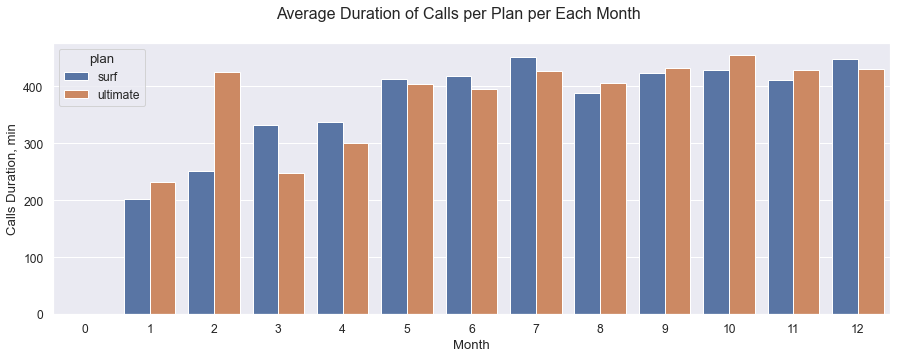

In [43]:
# Comparing average duration of calls per each plan per each month.
# as we saw above calls_duration distribution is skewed, so the median would be a better choice  
# (rather than the mean) for representing average duration.

calls_duration_pivot = df_total_plans.groupby(['plan','month'])['calls_duration'].median().reset_index()
calls_duration_pivot['month'] = calls_duration_pivot['month'].astype('int')

fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle("Average Duration of Calls per Plan per Each Month", fontsize=16)
sns.barplot(x='month', y="calls_duration", hue='plan', data=calls_duration_pivot)
plt.ylabel('Calls Duration, min')
plt.xlabel('Month');

As we can see above, except for some differences in February and March, on Surf and Ultimate plans users speak more or less  similar number of minutes per month. 

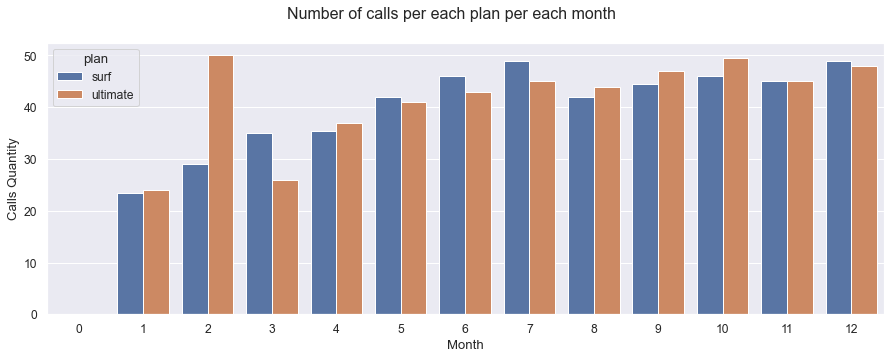

In [64]:
# Compare the number of calls users of each plan require each month. 
calls_number_pivot = df_total_plans.groupby(['plan','month'])['calls_number'].median().reset_index()
calls_number_pivot['month'] = calls_number_pivot['month'].astype('int')

fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle("Number of calls per each plan per each month", fontsize=16)
sns.barplot(x='month', y="calls_number", hue='plan', data=calls_number_pivot);
plt.xlabel('Month')
plt.ylabel('Calls Quantity');

As well except for some differences in February and March, on Surf and Ultimate plans users make more or less similar number of calls per month.

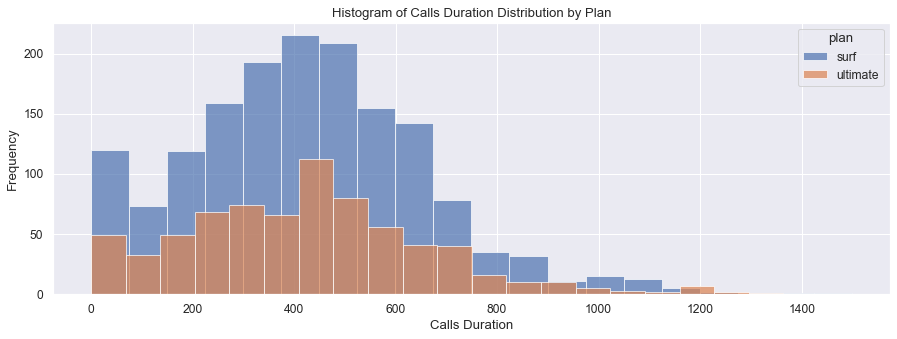

In [62]:
# let's check calls distributions on both plans
df_total_plans.groupby('plan')['calls_duration'].hist(bins=20,alpha = 0.7, legend=True, figsize=(15,5))

plt.xlabel('Calls Duration')
plt.ylabel('Frequency')
plt.title('Histogram of Calls Duration Distribution by Plan')
plt.legend(title='Plan');

In [46]:
# checking share of zeros in duration
(df_total_plans.query('calls_duration==0').groupby(by = 'plan')['calls_duration'].count()
    /df_total_plans.groupby(by = 'plan')['calls_duration'].count())*100

plan
surf        2.216593
ultimate    1.657459
Name: calls_duration, dtype: float64

- the shapes of distributions look pretty similar. Both look close to normal but with positive skewness. 
- the middle of both distributions is close to 400 minutes duration of calls per month.
- right at the histogram we can note a bit more than twice higher number of users on the Surf plan.
- on both plans there are about 1-2% of users that don't use voice communication service (most likely they use their plans just for Internet surfing)

We are going to build boxplots for our analysis and use them many times in a common way. So creating a function seems to be a good idea for this purpose. 

In [47]:
def boxplots(df, category, x_parameter,  y_parameter, order=True, notch=False, show_outliers=True):
    
    """ 
    The function builds boxplots for each unique value of a selected category of a dataframe we study.
    
    As input this function takes:
     - dataframe
     - x axis parameter
     - y axis parameter    
     - order parameter: if its value is "True" - the boxplots are sorted by boxplots' medians in ascending order, 
     if its value is "False" or "None" - in default order     
     - notch parameter -  whether to show notches on boxplots (for more evident medians indication)
     - show_outliers parameter - whether to show outliers
    
    As output the function presents:      
     - boxplots for each unique value of a selected category of a dataframe     
          
    """       
    # preventing data overwriting while running the "for" circle
    df_basic = df  
    
    # going through all unique names of a selected category, the further code would be applied to each of them       
    for unique_name in df[category].unique(): 
        
        # assigning data the boxplots will be built on
        df = df_basic[df_basic[category]==unique_name]  
        
        # checking conditions for sorting boxplots by their medians values
        if order==True:
            boxplot_order = df.groupby(x_parameter)[y_parameter].median().sort_values(ascending=True).index
        else:    
            boxplot_order=None
        
        # plotting boxplot with relevant subtitles
        fig, ax = plt.subplots(figsize=(15, 5))
        plt.suptitle(f'Boxplot of {y_parameter} by {str.capitalize(x_parameter)} for the {str.capitalize (unique_name)} plan', fontsize=16)
        sns.boxplot(x=df[x_parameter], y=df[y_parameter],\
            boxprops=dict(alpha=0.5), order=boxplot_order, 
            notch=notch, showfliers=show_outliers)

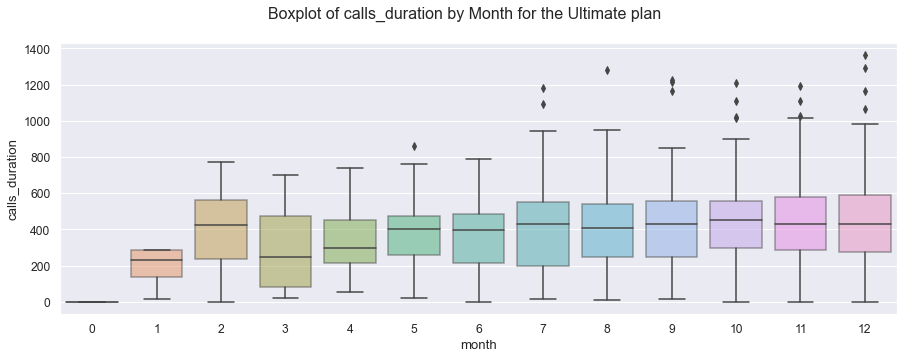

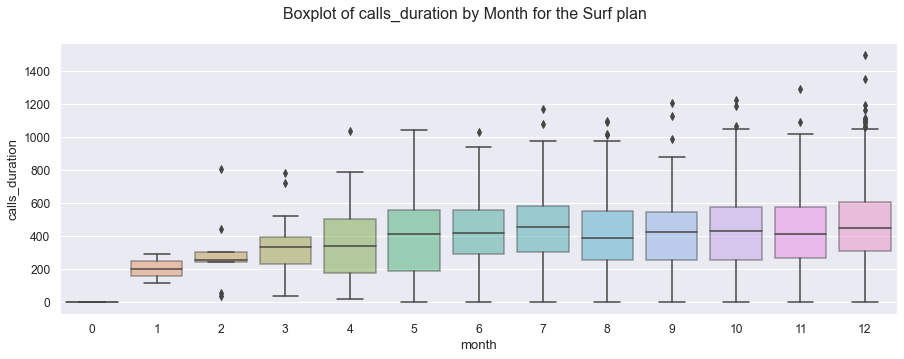

In [48]:
# Plotting boxplots to visualize the distributions of the monthly call duration by each plan
boxplots(df=df_total_plans, category ='plan', x_parameter='month', y_parameter='calls_duration',\
         order=False, notch=False, show_outliers=True)

- we don't see any strong patterns of users calling activity depending on the plan.
- except of February on the Ultimate plan users of both plans tend to spend less time talking in the first 4 month of the year.
- and **with the exception of the first four months of the year, users generally speak approximately the same number of minutes per month on each plan** (there are some minor outliers but they don't affect the total picture).
- we can guess that these smaller figures in Jan-April at the Surf plan and in Jan at Ultimate plan could be due to growing client base. But since this question is not connected with our study, we won't dig deeper for that. 

### Messages

In [49]:
# Calculating the mean, the median and the variance of messages monthly   
df_total_plans.pivot_table(index = ['plan','month'], values = 'messages_number', \
                                                  aggfunc = ('median','mean','var'), margins=False).round()

mean  median     var
plan     month                      
surf     0       0.0     0.0     0.0
         1      10.0    10.0   220.0
         2      12.0     3.0   386.0
         3      15.0     7.0   347.0
         4      17.0    10.0   502.0
         5      24.0    15.0   847.0
         6      25.0    15.0   915.0
         7      27.0    20.0   924.0
         8      29.0    20.0  1030.0
         9      31.0    22.0  1004.0
         10     34.0    26.0  1275.0
         11     32.0    27.0  1065.0
         12     39.0    31.0  1458.0
ultimate 0       0.0     0.0     0.0
         1      16.0    12.0   314.0
         2      22.0    15.0   478.0
         3      20.0    12.0   654.0
         4      22.0    17.0   544.0
         5      32.0    19.0  1297.0
         6      29.0    21.0   858.0
         7      33.0    28.0   960.0
         8      38.0    36.0  1196.0
         9      38.0    32.0  1051.0
         10     39.0    35.0  1221.0
         11     39.0    32.0  1233.0
         12     45.0    41.0  1549.0

According to the descriptive statistics in the pivot table above **people using the Ultimate plan send messages much more intensively in comparison with users of the Surf plan**. It's easily seen on the monthly bases and in general - in the pivot table build before (in general figures on services consumption).

Comparing average number of messages per each plan per each month.  
As we saw earlier the distribution of messages is skewed, so the median would be a better choice (rather than the mean) for representing average number of messages.

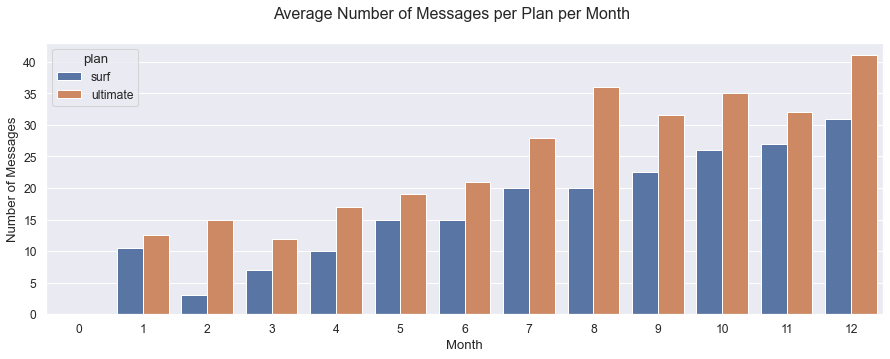

In [65]:
messages_number_pivot = df_total_plans.groupby(['plan','month'])['messages_number'].median().reset_index()
messages_number_pivot['month'] = messages_number_pivot['month'].astype('int')

fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle("Average Number of Messages per Plan per Month", fontsize=16)
sns.barplot(x='month', y="messages_number", hue='plan', data=messages_number_pivot)
plt.xlabel('Month')
plt.ylabel('Number of Messages');

Each month, especially in February users of the Ultimate plan send more messages.

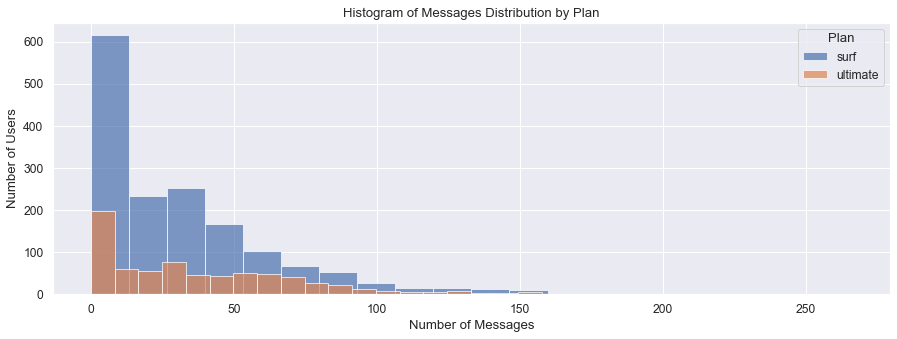

In [67]:
# let's check messages distributions on both plans
df_total_plans.groupby('plan')['messages_number'].hist(bins=20, alpha = 0.7, legend=True, figsize=(15,5))

plt.xlabel('Number of Messages')
plt.ylabel('Number of Users')
plt.title('Histogram of Messages Distribution by Plan')
plt.legend(title='Plan');

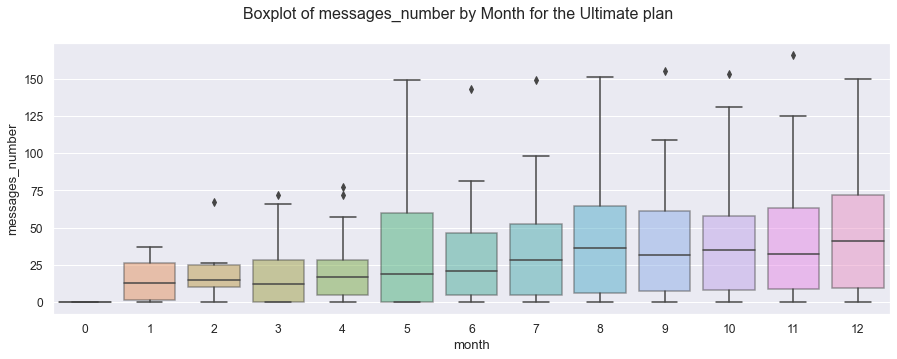

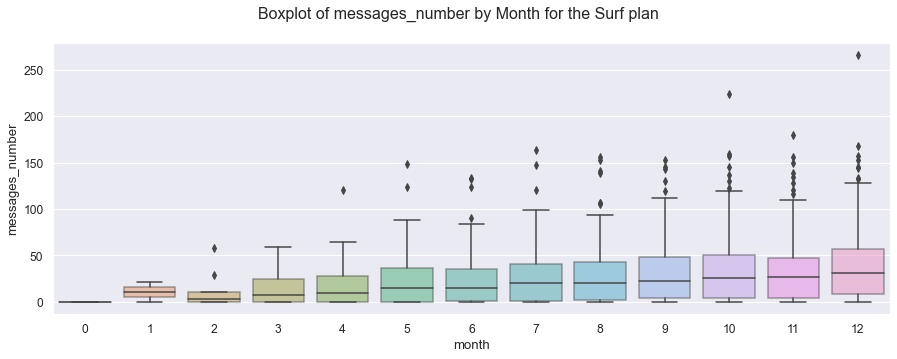

In [52]:
# Plotting boxplots to visualize the distributions of messages by month by each plan
boxplots(df=df_total_plans, category ='plan', x_parameter='month', y_parameter='messages_number',\
         order=False, notch=False, show_outliers=True)

- we do see patterns of users' messaging activity depending on the plan.
- **users of the Ultimate plan in general write messages more actively**; the range of messages number differ by month more significantly comparing to the Serf plan (it's very well seen on the boxplot of e.g. May and Aug)  
- mainly except of Jan figures of the Surf plan, users tend to send more messages each new month.

### Internet

In [53]:
# Calculating the mean, the median and the variance of internet consumption monthly   
df_total_plans.pivot_table(index = ['plan','month'], values = 'gb_used', \
                                                  aggfunc = ('median','mean','var'), margins=False).round()

mean  median    var
plan     month                     
surf     0       0.0     0.0    0.0
         1       5.0     5.0   18.0
         2      12.0    12.0   41.0
         3      14.0    14.0   64.0
         4      12.0    12.0   56.0
         5      14.0    14.0   58.0
         6      15.0    16.0   48.0
         7      17.0    17.0   61.0
         8      17.0    17.0   71.0
         9      17.0    17.0   49.0
         10     17.0    18.0   61.0
         11     16.0    17.0   55.0
         12     18.0    18.0   69.0
ultimate 0       0.0     0.0    0.0
         1       7.0     8.0   15.0
         2      17.0    20.0   38.0
         3      18.0    21.0  139.0
         4      16.0    16.0   86.0
         5      17.0    17.0   54.0
         6      15.0    15.0   69.0
         7      16.0    15.0   64.0
         8      18.0    18.0   58.0
         9      17.0    16.0   47.0
         10     18.0    17.0   55.0
         11     17.0    17.0   54.0
         12     18.0    17.0   59.0

According to the descriptive statistics in the pivot table above **users consume an approximately the same number of GB on both plans monthly**. The **one exception we should mention - in February** on the Ultimate plan. This month average Internet consumption on the Ultimate plan was much higher of that on the Surf plan (20 and 12 GB -respectively).

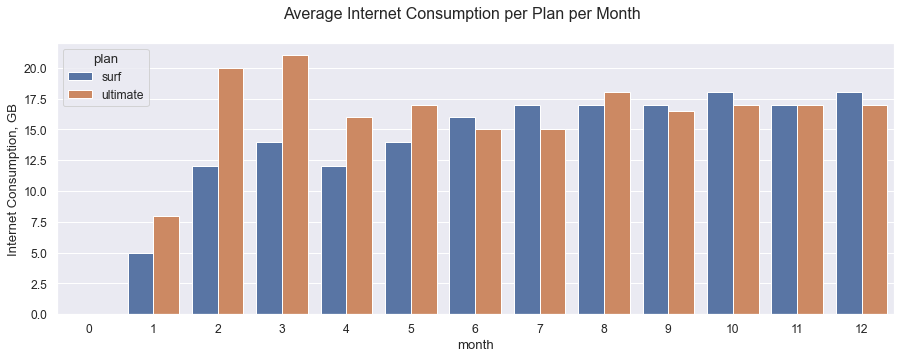

In [54]:
# Comparing average number Internet consumption per each plan per each month.
# as we saw earlier the distribution of messages is skewed, so the median whould be a better choise  
# (rather than the mean) for representing average number of messages.

gb_used_pivot = df_total_plans.groupby(['plan','month'])['gb_used'].median().reset_index()
gb_used_pivot['month'] = gb_used_pivot['month'].astype('int')

fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle("Average Internet Consumption per Plan per Month", fontsize=16)
sns.barplot(x='month', y="gb_used", hue='plan', data=gb_used_pivot)
plt.ylabel('Internet Consumption, GB');

In the first 4-5 month users of the Ultimate plan consume significantly higher volume of traffic, the rest of month Internet consumption is approximately at the same level. 

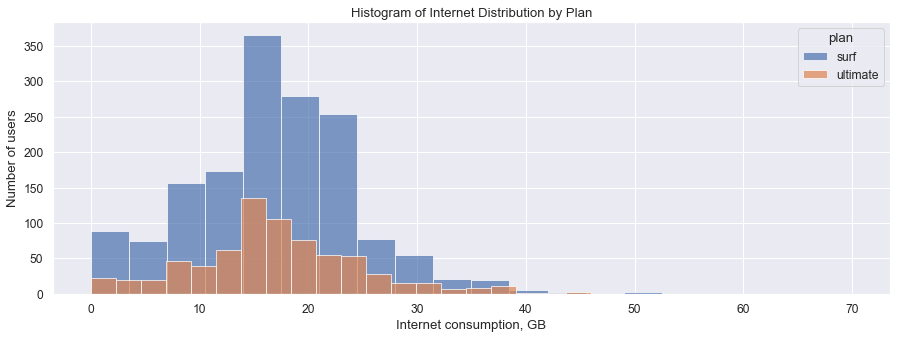

In [55]:
# let's check Internet consumption distributions on both plans
df_total_plans.groupby('plan')['gb_used'].hist(bins=20,alpha = 0.7, legend=True, figsize=(15,5))

plt.xlabel('Internet Consumption, GB')
plt.ylabel('Number of Users')
plt.title('Histogram of Internet Distribution by Plan')
plt.legend(title='Plan');

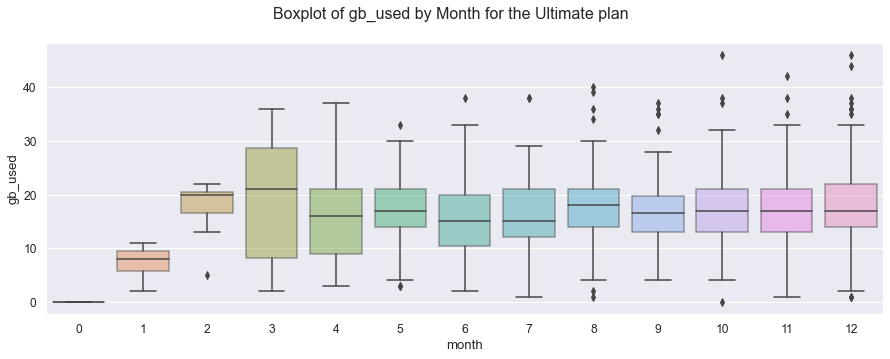

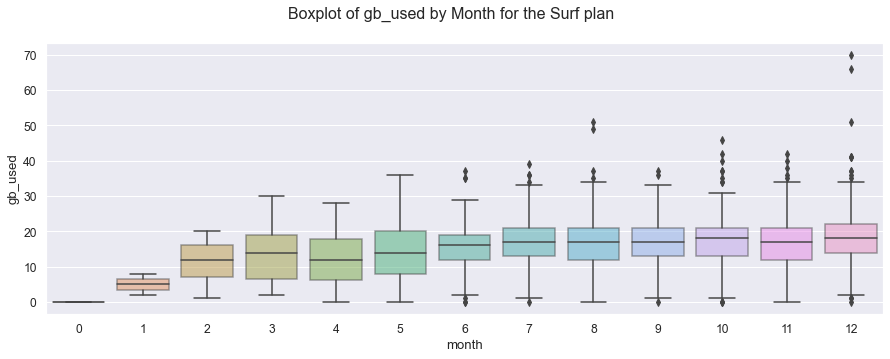

In [56]:
# Plotting a boxplot to visualize the distribution of the monthly Internet consumption on each plan
boxplots(df=df_total_plans, category ='plan', x_parameter='month', y_parameter='gb_used',\
         order=False, notch=False, show_outliers=True)

we don't see any strong patterns of users' Internet consumption habits depending on the plan.

## 💰 Studying Revenues

In [57]:
# let's glance at general information about the plans profitability 

# total profit
df_total_plans_pivot_profit = df_total_plans.pivot_table(
    index = ['plan'],
    values = 'full_profit',
    aggfunc = ('count','sum','median','mean','var','std')
    ).round()                  

df_total_plans_pivot_profit

# profit per service
df_total_plans_pivot_profit_per_service = df_total_plans.pivot_table(
    index = ['plan'],
    values = ['calls_profit', 'messages_profit','gb_profit', 'usd_monthly_pay'],
    aggfunc = 'sum'
    ).round()
                                    
df_total_plans_pivot_profit_per_service 

# profit per service per month
df_total_plans.groupby(['plan','month'])[['calls_profit', 'messages_profit','gb_profit', 'usd_monthly_pay']].sum()

,count,mean,median,std,sum,var
plan,,,,,,
surf,1579,61.0,40.0,55.0,95549.0,3061.0
ultimate,724,72.0,70.0,11.0,52346.0,129.0


,calls_profit,gb_profit,messages_profit,usd_monthly_pay
plan,,,,
surf,2839.0,60800.0,331.0,31580
ultimate,0.0,1666.0,0.0,50680


calls_profit  messages_profit  gb_profit  usd_monthly_pay
plan     month                                                           
surf     0              0.00             0.00        0.0              120
         1              0.00             0.00        0.0               40
         2              9.27             0.24      120.0              180
         3             15.81             0.39      580.0              460
         4             51.51             2.61      980.0             1000
         5            124.56             9.66     1990.0             1540
         6            152.40            14.49     2670.0             1940
         7            260.82            17.58     4880.0             2420
         8            261.18            29.19     6820.0             3240
         9            272.07            36.09     7110.0             3880
         10           415.65            59.58    10280.0             4740
         11           484.62            59.64    10200.0             5660
         12           790.62           101.46    15170.0             6360
ultimate 0              0.00             0.00        0.0              280
         1              0.00             0.00        0.0              280
         2              0.00             0.00        0.0              490
         3              0.00             0.00       56.0              840
         4              0.00             0.00       63.0             1470
         5              0.00             0.00       21.0             2030
         6              0.00             0.00       77.0             3290
         7              0.00             0.00      112.0             4130
         8              0.00             0.00      203.0             4970
         9              0.00             0.00      175.0             6020
         10             0.00             0.00      245.0             7420
         11             0.00             0.00      217.0             8890
         12             0.00             0.00      497.0            10570

- in total figures, the Surf plan brings more money to the company, mostly due to more than twice higher number of users.
- profit per user is higher on the Ultimate plan (70 against 40 dollars -respectively, if we take in account medians).
- most money in Surf plan comes from Internet usage over the included limit. It brings approximately a double sum of that from plan payments itself.
- almost all money in the Ultimate plan comes from subscription fees.
- Standard Deviation and Variance differ a lot between the plans (e.g. variance on the Surf plan is 3067, against 130 on the Ultimate plan)

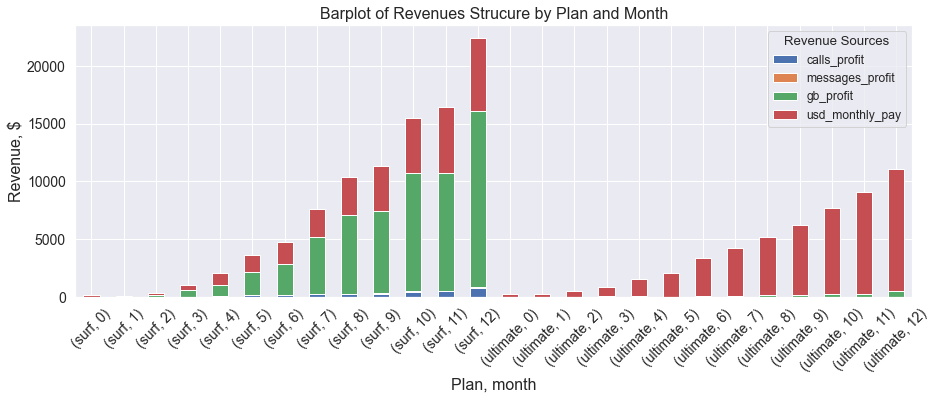

In [71]:
# studying revenues from services by plan and month
df_total_plans.groupby(['plan','month'])[['calls_profit', 'messages_profit','gb_profit', 'usd_monthly_pay']].sum()\
    .plot(kind='bar', stacked=True, figsize=(15,5), fontsize=14, rot=45);

plt.legend(title='Revenue Sources')
plt.ylabel('Revenue, $', fontsize=16)
plt.xlabel('Plan, month', fontsize=16)
plt.title('Barplot of Revenues Strucure by Plan and Month', fontsize=16);

The profit is growing each month on each plan. On the Surf plan most revenues come from Internet usage, on the Ultimate plan almost all revenues come from monthly fees. 

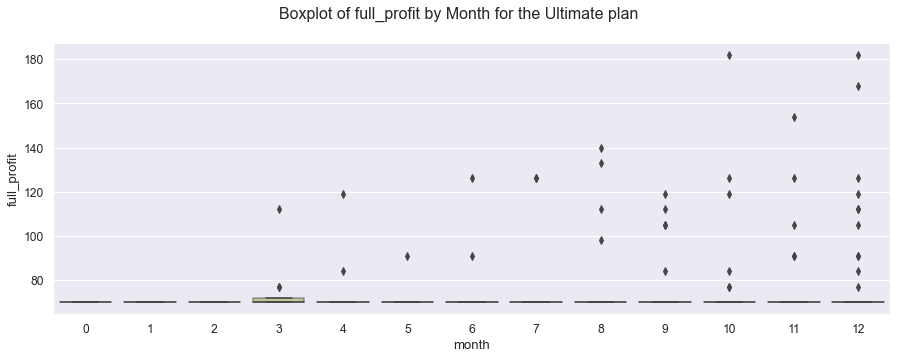

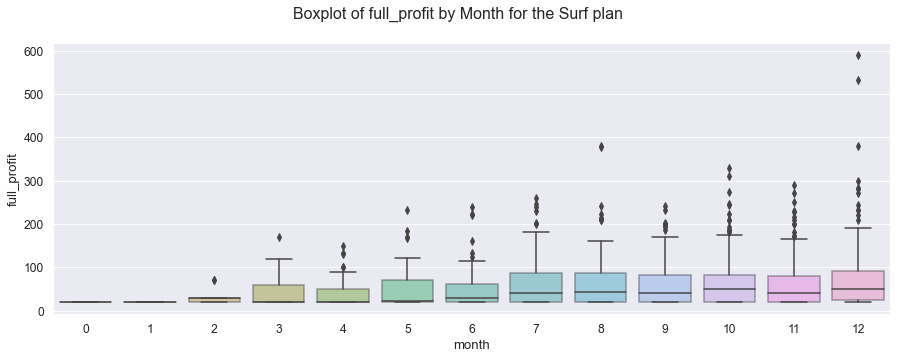

In [77]:
# Plotting boxplots to visualize the distributions of the monthly profit consumption on each plan
boxplots(df=df_total_plans, category ='plan', x_parameter='month', y_parameter='full_profit',\
         order=False, notch=False, show_outliers=True)

- revenues ranges on the Surf plan vary a lot. 
- revenues on the Ultimate plan in average stay the same per each user - very close to the monthly fee, with very modest range of values.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

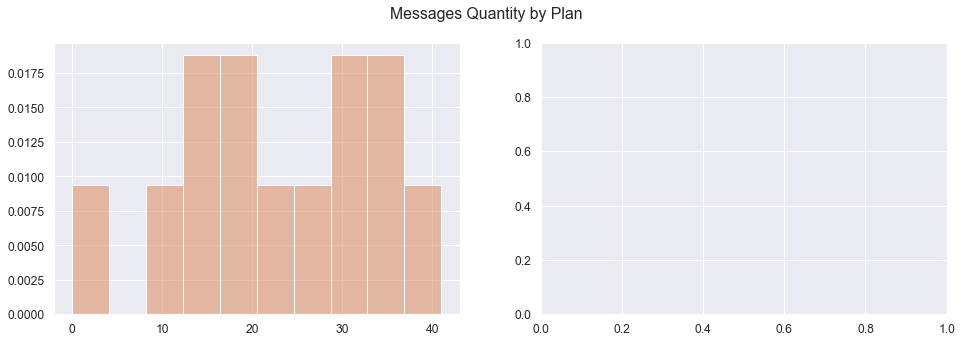

In [102]:
#  using a two-column subplot to display two different chats next to each other
fig, axes = plt.subplots(1,2, figsize=(16, 5))

plt.suptitle('Messages Quantity by Plan')
# Create a histogram for both plans
sns.histplot(data=messages_number_pivot, x='messages_number', hue='plan', kde=True, stat="density", bins=10, ax=axes[0])
# Create boxplots for both plans
sns.boxplot(data=messages_number_pivot, x=messages_number_pivot['messages_number'], y='plan', hue='plan', ax=axes[1]);

## 🧪 Testing Statistical Hypotheses

### Hypothesis №1: Average revenue on Ultimate and Surf calling plans differs.

Let's formulate hypotheses.  
**Null Hypothesis**: The average revenue from users of the Ultimate and Surf calling plans is equal.  
**Alternative Hypothesis**: The average revenue from users of the Ultimate and Surf plans is not equal.

<!-- <div style="background-color:#CCFFCC; padding:5px;">
Let's formulate the null hypothesis as: the average revenue from users of the Ultimate and Surf calling plans are equal.
</div>

<div style="background-color:#FFCCCC; padding:5px;">
Than the alternative hypothesis would be: the average revenue from users of the Ultimate and the Surf plans are NOT equal.
</div>

In [76]:
# Since we deal with comparing means of distributions, 
# ttest_ind method from scipy library would be appropriate for this purpose

alpha = 0.05  # let's use classical critical statistical significance level value
              # and if the p-value is less than alpha, we will reject the hypothesis

df_profit_surf = df_total_plans.query('plan=="surf"')['full_profit']
df_profit_ultimate = df_total_plans.query('plan=="ultimate"')['full_profit']

results = st.ttest_ind(
    df_profit_surf,
    df_profit_ultimate,
    equal_var = False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  9.730181872851229e-16
We reject the null hypothesis


In [ ]:
alpha = 0.05

# Data preparation
df_profit_surf = df_total_plans.query('plan=="surf"')['full_profit']
df_profit_ultimate = df_total_plans.query('plan=="ultimate"')['full_profit']

# Perform t-test
results = st.ttest_ind(df_profit_surf, df_profit_ultimate, equal_var=False)

# Set color for print
def color_print(text, color):
    print(f"\033[{color}m{text}\033[0m")

# Print results
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    color_print("We reject the null hypothesis", "1;31")  # Red color
else:
    color_print("We can't reject the null hypothesis", "1;32")  # Green color


In [ ]:
alpha = 0

# Data preparation
df_profit_surf = df_total_plans.query('plan=="surf"')['full_profit']
df_profit_ultimate = df_total_plans.query('plan=="ultimate"')['full_profit']

# Perform t-test
results = st.ttest_ind(df_profit_surf, df_profit_ultimate, equal_var=False)

# Set color for print
def color_print(text, background_color):
    print(f"\033[48;5;{background_color}m{text}\033[0m")

# Print results
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    color_print("We reject the null hypothesis", 1)  # Red background (ANSI color code 1)
else:
    color_print("We can't reject the null hypothesis", 2)  # Green background (ANSI color code 2)


Since the p-value is lower than alpha of 0.05, we can conclude that the datasets on the plans revenues are different. Thus we reject the null hypothesis, and say that the alternative hypothesis is true - the average revenue from users of the Ultimate and the Surf plans are not equal. This conclusion corresponds with our previous analysis.

### Hypothesis №2: Average Revenue in the NY-NJ Area and in the Other Regions is Different

<font color="green">
Let's formulate the NULL hypothesis as: the average revenue from users in the NY-NJ area is equal to that of the users from the other regions.
<br>

<font color="#8B0000">
Than the alternative hypothesis would be: the average revenue from users in the NY-NJ area is NOT equal to that of the users from the other regions.
</font>


In [ ]:
# Since we deal with comparing means of distributions, 
# ttest_ind method from scipy library would be appropriate for this purpose

alpha = 0.05  # let's use classical critical statistical significance level value
              # and if the p-value is less than alpha, we will reject the hypothesis

df_profit_NY_NJ = df_total_plans.query('city=="New York-Newark-Jersey City, NY-NJ-PA MSA"')['full_profit']
df_profit_not_NY_NJ = df_total_plans.query('city!="New York-Newark-Jersey City, NY-NJ-PA MSA"')['full_profit']

results = st.ttest_ind(
    df_profit_NY_NJ,
    df_profit_not_NY_NJ,
    equal_var = False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

Since the p-value is lower than alpha of 0.05, we can conclude that the datasets on the revenues from  NY-NJ area and others are different. Thus we reject the null hypothesis, and say that the alternative hypothesis is true - the average revenue from users in the NY-NJ area is not equal to that of other regions. This conclusion corresponds with our previous analysis. Just in case let's check their means. 

In [ ]:
# checking means of revenues in NY-NJ area and other area
df_profit_NY_NJ.mean()
df_profit_not_NY_NJ.mean()

# difference in% between revenues in NY-NJ area and other area 
(df_profit_NY_NJ.mean()-df_profit_not_NY_NJ.mean())/df_profit_not_NY_NJ.mean()*100 

The difference in means is significant - over 8%. That fits well with the test results.

## 📝 General Conclusions and Recommendations <a name="general-conclusions-and-recommendations"></a>

## General conclusion

**At data preprocessing stage** 

- By use of info(), describe(), head(), stb.missing() and duplicated() methods we checked how the datasets in fact look like,  their data types, presence of missed values and duplicates. 

- We found and addressed the following issues: 
    - fixed the data types, from object to datetime, from float to integer, when needed.
    - in duration and `mb_used` we fixed unreasonable zero values, and we treated them as outliers.
    - no duplicates were detected.


**At data enrichment stage** 
- We enriched data for further analysis by adding appropriate fields:
    - months  for such categories as `call_date`, `message_date`, and `session_date`. 
    - added the `gb_used` column, based on the `mb_used` field.
    - calculated monthly revenues from each user. For that purpose we made the following steps:    
        - subtracted the free package limit from the total number of calls, text messages, and data.
        - multiplied the result by the calling plan value.
        - added the monthly charge depending on the calling plan.
        - we did it by merging different dataframes with some minor dataframes adjustment in order to make the merger smooth.
        

**At data analysis stage**  
- We built several pivot tables and graphs in order to study customers behavior. What we found out:
    - on both plans users speak approximately the same number of minutes per month.
    - the number of messages sent on the Ultimate plan is significantly higher than that on the Surf plan (30 and 24 - respectively).
    - Internet consumption is at the same level on both plans.
    - standard deviations and variances are pretty close for all the services at both plans.
    
- We studied profitability of the Surf and the Ultimate plans. What we found out:
    - in total figures, the Surf plan brings more money to the company, mostly due to higher number of users.
    - profit per user is higher on the Ultimate plan (70 against 40 dollars -respectively, if we take in account medians).
    - most money in Surf plan comes from Internet usage over the included limit. It brings approximately a double sum of that from plan payments itself.
    - almost all money in the Ultimate plan comes from subscription fees.
    - Standard Deviation and Variance differ a lot between the plans (e.g. variance on the Surf plan is 3067, against 130 on the Ultimate plan)

- By use of ttest_ind method from scipy library we tested two null hypothesis. The tests results are following:  
    - we reject the null hypothesis, and stated that the alternative hypothesis is true - the average revenue from users of the Ultimate and the Surf plans are not equal.
    - we reject the second null hypothesis as well, and stated that the alternative hypothesis is true - the average revenue from users in the NY-NJ area is not equal to that of other regions.

### 🎯 Recommendations    
- Let's recollect, the project's main goal was to assist the commercial department in making the right decision which plan to focus attention on (and allocate an appropriate advertising budget). 

- **Our study shows that the Ultimate plan is more profitable**. Users on the Serf plan even when paying for services exceeding their plan's limits on average bring less money to the company. So **we would definitely recommend investing in Ultimate plan promotion**.